In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# read the left image
image_left = cv2.imread('left.jpg',0)
# read the right image
image_right = cv2.imread('right.jpg',0)

In [91]:
# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# find the keypoints with ORB
kp1 = orb.detect(image_left,None)
kp2 = orb.detect(image_right,None)
# compute the descriptors with ORB
kp1, des1 = orb.compute(image_left, kp1)
kp2, des2 = orb.compute(image_right, kp2)
image1_copy= image_left
image2_copy= image_right

image1_copy = cv2.drawKeypoints(image_left,kp1,None,(255,0,0),4)
image2_copy = cv2.drawKeypoints(image_right,kp2,None,(255,0,0),4)
cv2.imshow("Left image",image1_copy)
cv2.imshow("Right image",image2_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [92]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [93]:
good = []
points1 = []
points2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        points1.append(kp1[m.queryIdx].pt)
        points2.append(kp2[m.trainIdx].pt)

In [94]:
points1 = np.int32(points1)
points2 = np.int32(points2)
# This is an important step. So here we need to find the fundamental matrix
F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_LMEDS)

print("Fundamental matrix:\n", F)

# We select only inlier points
points1 = points1[mask.ravel()==1]
points2 = points2[mask.ravel()==1]

Fundamental matrix:
 [[ 2.71481522e-06  2.52435756e-05 -3.25557956e-03]
 [ 3.56631129e-06  4.33140192e-06 -9.95212605e-03]
 [-3.67578767e-04 -5.77305888e-04  1.00000000e+00]]


In [95]:
# Function for drawing lines
def drawlines(image1,lines,points1,points2):
    rows,columns = image1.shape
    image1 = cv2.cvtColor(image1,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,points1,points2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [columns, -(r[2]+r[0]*columns)/r[1] ])
        image1 = cv2.line(image1, (x0,y0), (x1,y1), color,1)
    return image1
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
epilines_left = drawlines(image_left,lines1,points1,points2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
epilines_right = drawlines(image_right,lines2,points2,points1)

cv2.imshow("Left image",epilines_left)
cv2.imshow("Right image",epilines_right)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Extraxting only few points and lines

In [100]:
image1_copy = cv2.drawKeypoints(image_left,kp1[::8],None,(255,0,0),4)
image2_copy = cv2.drawKeypoints(image_right,kp2[::8],None,(255,0,0),4)

cv2.imwrite("image1_copy.jpg", image1_copy)
cv2.imwrite("image2_copy.jpg", image2_copy)

True

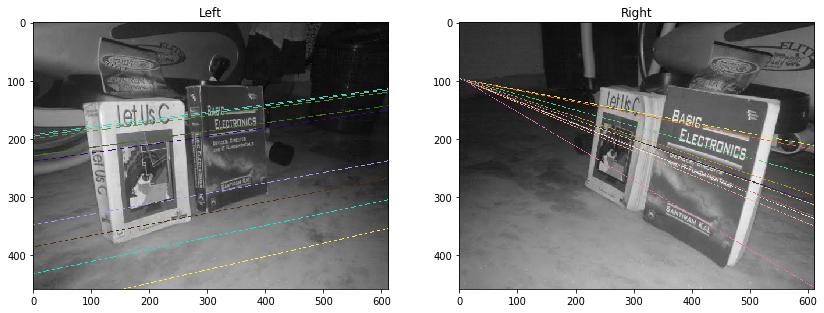

In [96]:
lines1 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
epilines_left = drawlines(image_left,lines1[::8],points1,points2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
epilines_right = drawlines(image_right,lines2[::8],points2,points1)


fig, axes = plt.subplots(1, 2, figsize=(14, 14))
axes[0].imshow(epilines_left, cmap='gray')
axes[0].set_title('Left')

axes[1].imshow(epilines_right, cmap='gray')
axes[1].set_title('Right')

fig.savefig('Result.png')